In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from matplotlib import animation
from IPython.display import HTML
import matplotlib
import random

This notebook presents very preliminary (pre-pilot) data from the experiment on gap acceptance decisions in left turn across path scenario. We had two subjects making 30 left turns each (randomly mixed with 10 right turns and 10 "no turns"). We manipulated TTA of the oncoming vehicle: each subject made ten decisions for TTA=3, 4.5, and 6s; distance was randomly chosen from 80, 120, and 160m, speed was determined as distance/TTA.

This small pre-pilot dataset can only help us to fine-tune the parameteres of the experiment setup, we cannot yet draw any conclusions regarding our hypotheses, but it's useful to look at the results anyway

# Preprocess data

For convenience, merge data files for all subjects into one file

In [3]:
def merge_txt_files(data_path='data'):
    dfs = []
    for file in os.listdir(data_path):
        file_path = os.path.join(data_path, file)
        if file_path.endswith('.txt'):
            print(file_path)
            dfs.append(pd.read_csv(file_path, sep='\t'))
    df_concat = pd.concat(dfs)
    df_concat.to_csv(os.path.join('raw_data_merged.txt'), index=False, sep='\t')

merge_txt_files()

data\120_1_2019_08_20_15_35.txt
data\305_1_2019_08_20_14_43.txt


Response time (RT) is defined as the time between the momen the bot appeared in front of the subject (`idx_bot_spawn`) and the moment the subject pressed the acceleration pedal (`idx_throttle`)

In [19]:
def get_measures(traj):
    '''
    This function extracts dependent variables and some other useful things from an individual trajectory.    
    The time of bot spawn is the first time bot_a is less than 10% of its max value (after the ego car slows
    down to 0.5 m/s). 
    '''
    if sum(traj.ego_v<1):
        idx_slowdown = (traj.ego_v<0.5).to_numpy().nonzero()[0][0]
        bot_a_max = traj.bot_a.max()        
        idx_bot_spawn = idx_slowdown + (traj[idx_slowdown:].bot_a<0.1*bot_a_max).to_numpy().nonzero()[0][0]
        throttle = traj.iloc[idx_bot_spawn:, traj.columns.get_loc('throttle')]
        idx_response = idx_bot_spawn + (throttle>0).to_numpy().nonzero()[0][0]
        RT = traj.t[idx_response] - traj.t[idx_bot_spawn]
        idx_min_distance = idx_bot_spawn + np.argmin(traj.d_ego_bot[idx_bot_spawn:].values)
        min_distance = min(traj.d_ego_bot[idx_bot_spawn:].values)
    else:
        # if the driver never decelerated to <1m/s, the bot did not spawn
        idx_bot_spawn = -1
        idx_response = -1
        idx_min_distance = -1
        min_distance = -1
        RT = -1
    return pd.Series({'idx_bot_spawn': idx_bot_spawn,
                      'idx_response': idx_response,
                      'idx_min_distance': idx_min_distance,
                      'min_distance': min_distance,
                      'RT': RT})

def get_data(data_file='raw_data_merged.txt'):
    data = pd.read_csv(data_file, sep='\t', index_col=['subj_id', 'session', 'route', 'intersection'])
    data.loc[:,'t'] = data.t.groupby(data.index.names).transform(lambda t: (t-t.min()))/1000
    
    # we are only intersted in left turns
    data = data[data.turn_direction==1]

    # only consider the data recorded within 10 meters of each intersection
    data = data[abs(data.distance_to_intersection)<10]

    # smooth the time series by filtering out the noise using Savitzky-Golay filter
    apply_filter = lambda traj: savgol_filter(traj, window_length=21, polyorder=2, axis=0)
    cols_to_smooth = ['ego_x', 'ego_y', 'ego_vx', 'ego_vy', 'ego_ax', 'ego_ay', 
                      'bot_x', 'bot_y', 'bot_vx', 'bot_vy', 'bot_ax', 'bot_ay']
    data.loc[:, cols_to_smooth] = (data.loc[:, cols_to_smooth].groupby(data.index.names).transform(apply_filter))

    # calculate absolute values of speed and acceleration
    data['ego_v'] = np.sqrt(data.ego_vx**2 + data.ego_vy**2)
    data['bot_v'] = np.sqrt(data.bot_vx**2 + data.bot_vy**2)    
    data['ego_a'] = np.sqrt(data.ego_ax**2 + data.ego_ay**2)
    data['bot_a'] = np.sqrt(data.bot_ax**2 + data.bot_ay**2)
    
    # calculate actual distance between the ego vehicle and the bot, and current tta for each t
    data['d_ego_bot'] = np.sqrt((data.ego_x - data.bot_x)**2 + (data.ego_y - data.bot_y)**2)    
    data['tta'] = data.d_ego_bot/data.bot_v
    
    ## temporary fixes for the pre-pilot data
    # tta was recorded as int, not float, so it was actually 4.5, not 4s
    data.loc[data['tta_condition']==4.0, 'tta_condition'] += 0.5

    # get the DVs and helper variables
    measures = data.groupby(data.index.names).apply(get_measures)
    
    data = data.join(measures)    
    
    # RT is -1 if a driver didn't stop and the bot did not appear at the intersection; we discard these trials
    data = data[data.RT>0]
    measures = measures[measures.RT>0]    
    
    # add the condition information to the measures dataframe for further analysis
    conditions = data.loc[:,['tta_condition', 'd_condition', 'v_condition']].groupby(data.index.names).first()
    measures = measures.join(conditions)

    return data, measures

In [32]:
data, measures = get_data()

# is_turn_decision is calculated based on the minimum distance ever observed between ego and bot during the interaction.
# If the cars were no closer to each other than the lane width (3.5m + 1.5 margin), we count this as a turn decision.
# Based on visual inspection of animations for all trials, this works in all but one trials.
measures['is_turn_decision'] = measures.min_distance > 5

# In one trial where this criterion didn't work, a subject hit a road sign after turning left, so the bot
# was less than 5m away from the ego car after the turn. We fix this manually.
measures.loc[(305, 1, 1, 8), ['is_turn_decision']] = True

# add column 'decision' for nicer visualization
measures['decision'] = 'Wait'
measures.loc[measures.is_turn_decision, ['decision']] = 'Turn'
measures_turn = measures[measures.is_turn_decision]

In [34]:
measures.describe()

,idx_bot_spawn,idx_response,idx_min_distance,min_distance,RT,tta_condition,d_condition,v_condition
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.00000,59.000000
mean,81.610169,255.322034,476.966102,18.040371,1.784847,4.525424,120.00000,28.152542
std,26.045065,136.725681,126.100667,19.276584,1.431894,1.260896,30.62566,10.741177
min,22.000000,117.000000,326.000000,2.679920,0.257000,3.000000,80.00000,13.000000
25%,60.500000,153.000000,406.000000,3.302941,0.690000,3.000000,80.00000,20.000000
50%,81.000000,190.000000,448.000000,3.577510,1.059000,4.500000,120.00000,26.000000
75%,104.000000,311.000000,533.000000,36.617662,2.402500,6.000000,160.00000,35.000000
max,128.000000,691.000000,1133.000000,58.849186,6.359000,6.000000,160.00000,53.000000


# Visualize decision dynamics

Let's take a look at the time course of an example "trial"

In [36]:
traj_id = (120,1,1,11)
traj = data.loc[traj_id]

In [37]:
def animate_traj(traj):
    idx_bot_spawn = int(traj.iloc[0].idx_bot_spawn)
    idx_response = int(traj.iloc[0].idx_response) - idx_bot_spawn
    tta = traj.iloc[0].tta_condition
    d = (np.sqrt((traj.ego_x[idx_bot_spawn]-traj.bot_x[idx_bot_spawn])**2 
                 + (traj.ego_y[idx_bot_spawn]-traj.bot_y[idx_bot_spawn])**2))
    v = d/tta
    min_distance = traj.iloc[0].min_distance
    dt = traj.t.diff().median()  
    
    traj_to_plot = traj[idx_bot_spawn:]    
    
    fig, ax = plt.subplots()
    
    margin = 5
    ax.set_xlim(( min(traj_to_plot.ego_x.min(), traj_to_plot.bot_x.min()) - margin, 
                 max(traj_to_plot.ego_x.max(), traj_to_plot.bot_x.max()) + margin))
    ax.set_ylim(( min(traj_to_plot.ego_y.min(), traj_to_plot.bot_y.min()) - margin, 
                 max(traj_to_plot.ego_y.max(), traj_to_plot.bot_y.max()) + margin))  

    marker_ego, = ax.plot([], [], marker='o', ls='', color='C0', label='ego')
    marker_bot, = ax.plot([], [], marker='s', ls='', color='C1', label='bot')
    line_ego, = ax.plot([], [], lw=2, ls='-', color='C0')
    line_bot, = ax.plot([], [], lw=2, ls='-', color='C1')

    def animate(i):
        marker_ego.set_data(traj_to_plot.ego_x[i], traj_to_plot.ego_y[i])
        marker_bot.set_data(traj_to_plot.bot_x[i], traj_to_plot.bot_y[i])
        line_ego.set_data(traj_to_plot.ego_x[:i], traj_to_plot.ego_y[:i])
        line_bot.set_data(traj_to_plot.bot_x[:i], traj_to_plot.bot_y[:i])

        return (marker_ego, marker_bot, line_ego, line_bot,)
    
    legend = ax.legend(fontsize=12)
    ax.set_title('TTA=%.1fs, d=%im, v=%.2fm/s, min_d=%.1fm' % (tta, d, v, min_distance), fontsize=14)
    
    anim = animation.FuncAnimation(fig, animate, frames=len(traj_to_plot), interval=int(1000*dt), blit=True)
    return anim

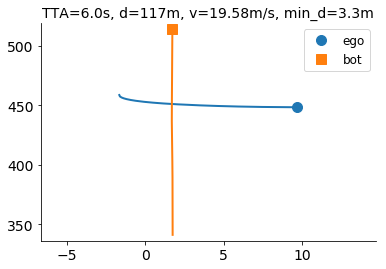

In [38]:
anim = animate_traj(traj)
HTML(anim.to_html5_video())
# HTML(anim.to_jshtml())

Let's take a look at the time course of the trials to see if the times of bot spawn (start of decision) and response (termination of a decision) are determined correctly

In [49]:
def plot_traj(traj, fig_path='figures'):    
    idx_bot_spawn = int(traj.iloc[0].idx_bot_spawn)
    idx_response = int(traj.iloc[0].idx_response)
    idx_min_distance = int(traj.iloc[0].idx_min_distance)
    tta = int(traj.iloc[0].tta_condition)
    d = int(traj.iloc[0].d_condition)
    
    fig, axes = plt.subplots(4, 1, figsize=(12,9), sharex=True)
    axes[0].plot(traj.t, traj.ego_v, color='C0')
    axes[0].plot(traj.t[idx_bot_spawn], traj.ego_v[idx_bot_spawn], color='C7', ls='', marker='o')
    axes[0].plot(traj.t[idx_response], traj.ego_v[idx_response], color='C7', ls='', marker='x')
    axes[0].set_ylabel('ego v')

    axes[1].plot(traj.t, traj.throttle, color='C1')
    axes[1].plot(traj.t[idx_bot_spawn], traj.throttle[idx_bot_spawn], color='C7', ls='', marker='o')
    axes[1].plot(traj.t[idx_response], traj.throttle[idx_response], color='C7', ls='', marker='x')
    axes[1].set_ylabel('ego throttle')

    axes[2].plot(traj.t[:], traj.d_ego_bot[:], color='C2')
    axes[2].plot(traj.t[idx_bot_spawn], traj.d_ego_bot[idx_bot_spawn], color='C7', ls='', marker='o')
    axes[2].plot(traj.t[idx_response], traj.d_ego_bot[idx_response], color='C7', ls='', marker='x')
    axes[2].set_ylabel('d(ego to bot)')

    axes[3].plot(traj.t[:], traj.tta[:], color='C3')
    axes[3].plot(traj.t[idx_bot_spawn], traj.tta[idx_bot_spawn], color='C7', ls='', marker='o', 
                 label='Oncoming car appears')
    axes[3].plot(traj.t[idx_response], traj.tta[idx_response], color='C7', ls='', marker='x', 
                 label='Decision is made')
    axes[3].set_ylabel('tta')
    axes[3].set_ylim((0, 7))

    axes[3].set_xlabel('time $t$')

    legend = fig.legend(loc='upper left', bbox_to_anchor=(1.0, 0.9), 
                        title=str(traj.iloc[0].name) + '\nTTA=%.1fs, d=%im' % (tta, d))
    legend.get_title().set_fontsize('18')
    plt.tight_layout()
    plt.savefig(os.path.join(fig_path, '%s.png' % (str(traj.iloc[0].name))))

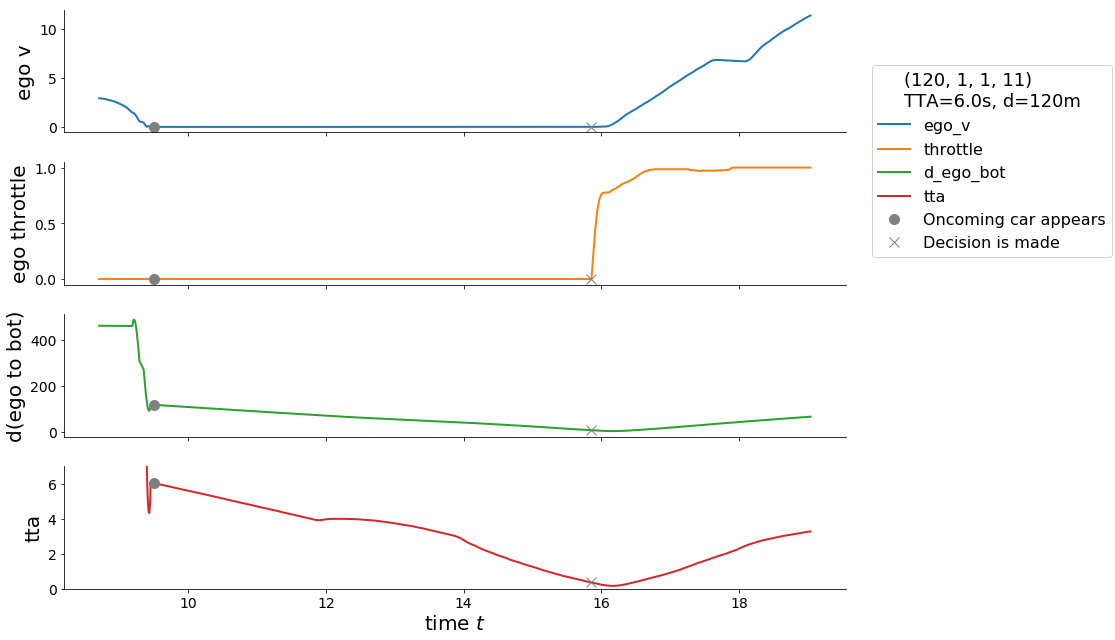

In [50]:
plot_traj(traj)

To check whether the algorithms of detecting 1) determining whether a driver decided to turn or to wait, 2) the momement the decision started (bot spawned), and 3) the moment decision was made, we save animations and time series plots for all trials

In [19]:
for name, traj in data[data.min_distance<5].groupby(data.index.names):
    anim = animate_traj(traj)
    anim.save('figures/wait/%s.mp4' % (str(traj.iloc[0].name)), dpi=300)
    plot_traj(traj, 'figures/wait')
    plt.close()

In [20]:
for name, traj in data[data.min_distance>5].groupby(data.index.names):
    anim = animate_traj(traj)
    anim.save('figures/turn/%s.mp4' % (str(traj.iloc[0].name)), dpi=300)
    plot_traj(traj, 'figures/turn')
    plt.close()

Visual inspection of all trials confirmed that the chosen algorithms accurately detect turn/wait decisions and response times. The only exception are response times in the trials where a subject started moving away but then changed their mind and decided to wait in the end. These RTs are short, although the decision is "wait"

In [41]:
measures[(measures.RT<1) & (measures['decision']=='Wait')]

idx_bot_spawn  idx_response  \
subj_id session route intersection                                
120     1       1     14                     22.0         117.0   
                2     14                     74.0         130.0   
305     1       2     2                      97.0         146.0   
                      12                    106.0         159.0   
                      16                     92.0         126.0   

                                    idx_min_distance  min_distance     RT  \
subj_id session route intersection                                          
120     1       1     14                       596.0      3.400827  0.978   
                2     14                       622.0      2.679920  0.575   
305     1       2     2                        405.0      3.119907  0.504   
                      12                       395.0      3.410376  0.545   
                      16                       394.0      3.292015  0.350   

                                    tta_condition  d_condition  v_condition  \
subj_id session route intersection                                            
120     1       1     14                      6.0           80           13   
                2     14                      4.5          160           35   
305     1       2     2                       3.0          160           53   
                      12                      3.0           80           26   
                      16                      3.0          120           40   

                                    is_turn_decision decision  
subj_id session route intersection                             
120     1       1     14                       False     Wait  
                2     14                       False     Wait  
305     1       2     2                        False     Wait  
                      12                       False     Wait  
                      16                       False     Wait

For instance, this one

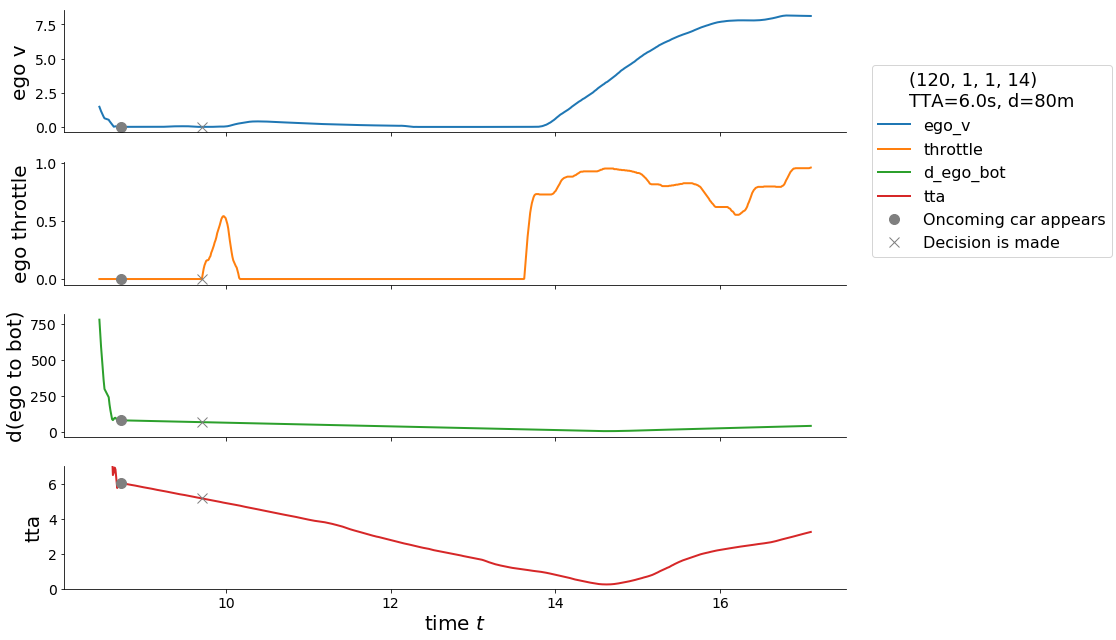

In [51]:
plot_traj(data.loc[random.choice(measures[(measures.RT<1) & (measures['decision']=='Wait')].index)])

In future, we will update the RT detection algorithm so that it ignores small movements of the car due to short presses of the gas pedal. These changes-of-mind will also be interesting to model, possibly using the extension of the DDM model by Resulaj et al (2009)

# Measures analysis

In [52]:
measures = measures.reset_index()
measures_turn = measures_turn.reset_index()

We need to determine whether the TTA conditions used for the pilot allow us to capture both "clear cut" and "borderline" decisions. For this, we take a look at whether p(turn) and RT are sensitive to TTA in the two subjects that we have had so far

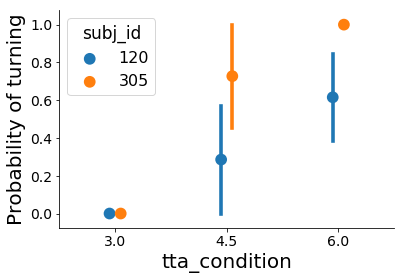

In [60]:
ax = sns.pointplot(data=measures, x='tta_condition', y='is_turn_decision', hue='subj_id', join=False, dodge=0.1)
ax.set_ylabel('Probability of turning');

We can already see individual differences in sensitivity to TTA. Maybe for the full-scale experiment we should use an adaptive procedure to fine-tune the range of TTA to get p(turn) ranging from 20% to 80% for each subject?

Now let's see if there are any abnormalities in the RTs. We could already see in some trials that in "wait" decisions RT is very short because of "changes-of-mind", but also people would normally start pressing the gas pedal before the oncoming car passes, so RT are usually less than tta_condition. So far we focus on the "turn" decisions, so we can ignore "wait" RTs altogether. Still, it's intersting to see RTs for all trials (but bear in mind that some "wait" trials will have weird RTs)

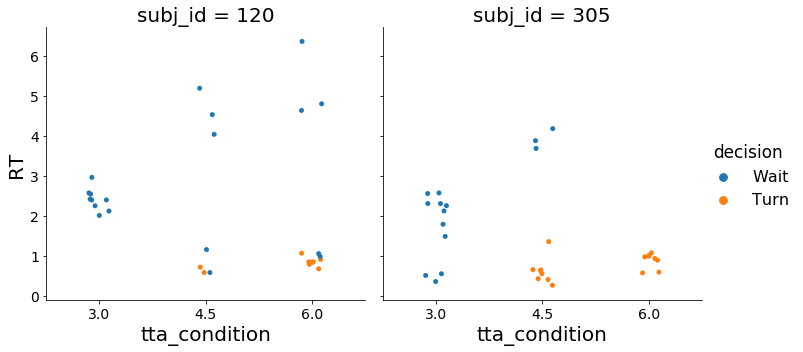

In [62]:
grid = sns.catplot(data=measures, x='tta_condition', y='RT', col='subj_id', hue='decision')

Zooming in on the 'turn' decisions, we look at RTs as a function of TTA

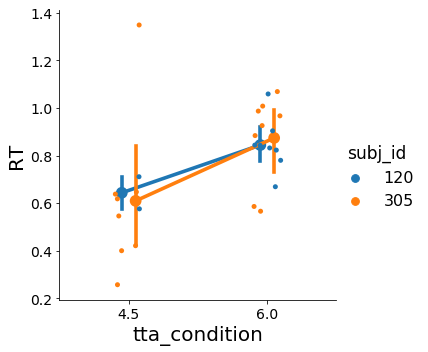

In [63]:
grid = sns.catplot(data=measures_turn, x='tta_condition', y='RT', hue='subj_id')
ax = grid.axes[0][0]
sns.pointplot(data=measures_turn, x='tta_condition', y='RT', hue='subj_id', ax=ax, alpha=0.5, dodge=0.1)
ax.legend().remove()

Interestingly, we have a positive relationship between RT and TTA condition, which isn't what would be predicted by the constant-drift-rate DDM. The latter implies that for low-probability decisions we have longest response times, while we see the opposite picture. Is that because the drift rate in our case decreases with time?

We are also not sure about whether TTA is the right perceptual quantity that describes the information that the drivers use when making a decision. It can be, for instance, some other combination of d and v. Let's take a look at the distance, for instance

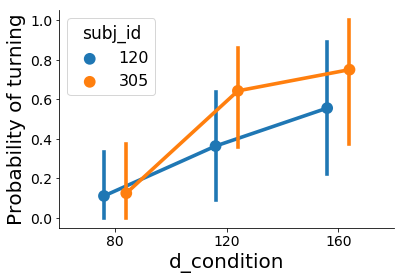

In [65]:
ax = sns.pointplot(data=measures, x='d_condition', y='is_turn_decision', hue='subj_id', join=True, dodge=0.2)
ax.set_ylabel('Probability of turning');

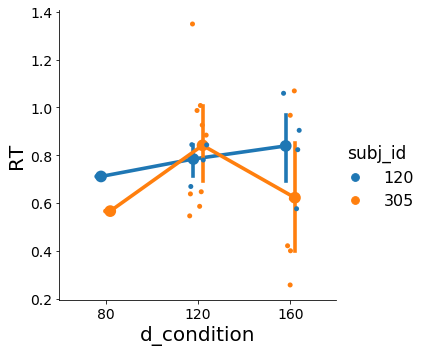

In [66]:
grid = sns.catplot(data=measures_turn, x='d_condition', y='RT', hue='subj_id')
ax = grid.axes[0][0]
sns.pointplot(data=measures_turn, x='d_condition', y='RT', hue='subj_id', ax=ax, alpha=0.5, dodge=0.1)
ax.legend().remove()

It seems that TTA is a stronger predictor of p(turn) and RT compared to d, which is in contrast to the literature on gap acceptance (e.g. Davis & Swenson 2004, who found that the opposite is true). However, we have very little data, so we shouldn't draw any conclusions at this stage

The two adjustments I'd  I see are 1) increasing TTA for the lowest TTA condition, 2) thinking about a proper adaptive procedure to determine individualized TTA conditions per subject.